In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from init_objects import *
from simfinmodel import *
from functions.helpers import hurst

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Decoupling fundamentals

Dirk Bezemer, Stefan Lundbergh & Joeri Schasfoort

## Introduction
These days, the markets are behaving oddly, as Gillian Tett pointed out recently. The term premium, reflecting preference for longer debt, is zero in the US and it is inverted globally. It should be positive in this stage of the business cycle. Investor appetite for new corporate debt remains large, despite its rapidly falling quality. House prices keep rising in many economies, despite interest rate rises. US equities are sought after, despite their valuations. Gold and the VIX are falling, despite geopolitical turmoil.
 
What explains? The usual suspects are investor overconfidence or complacency, thanks to loose monetary policy. But perhaps there is a larger pattern. Maybe these seemingly disconnected oddities are symptoms of a next stage in the evolution of the markets. Let’s call this ‘Index Capitalism’, following the American economist Hyman Minsky (1919-1996) who observed the evolution, from the 1980s onwards, of ‘Money Manager Capitalism’. Market economies revolved increasingly around managed money and its returns, and ever less around commerce and innovation. Minsky noted with  alarm that picking stocks had replaced entrepreneurship. 

But the world has changed. ‘Fundamental’ investors who actively pick stocks based on the quality of a company now manage a mere 10% of trading volume, according to JP Morgan. Capital is increasingly moving into index management. Index Capitalism may be today’s evolution of Money Manager Capitalism. This may help explain what will otherwise remain odd facts. For what unites the oddities is that prices keep deviating from what would seem to be their fundamental value.

This makes sense in a world where fundamental investors are on their way out. They have a view on a company’s fundamental value. When price falls below this  they buy, when it rises above what is deemed justifiable, they sell. If they do their homework on the company’s health and prospects, fundamental investors ensure that prices never stray too far from fundamental values. This is not to say they are rational investment machines. But their long-term behaviour stabilizes markets and channels capital to its most productive use.

Index capitalism doesn’t do this. Passive investors allocate capital based on mechanical rules, disconnected from the underlying company features. Market valuations are driven by investment flows to and from index funds, stock buybacks, and the relative popularity of different investment strategies, such as momentum-seeking, trend following and mean-reversion. These investment rules drive stock prices, with no reference to a company’s profit or productivity.

Of course, in the old Money Manager Capitalism financial markets also occasionally decoupled from the real economy. Every now and then investors go into a frenzy, forget fundamentals and pursue the froth in the market. But Index Capitalism simply does not distinguish fundamentals from froth and frenzy. The market becomes a self-referential system, played by mechanical rules. There are very few fundamental investors left to counteract price deviations from fundamentals. In Index Capitalism, features that are oddities in the old system of fundamental investors are bound to develop.

Whether we like it or not, Index Capitalism is here to stay. It is already branching into distinct varieties, like factor investing discussed in last week’s Big Read by Robin Wigglesworth. Yesteryear’s  oddities may be today’s new normal. Perhaps we need to update our frame of reference to understand its logic, just as Minsky did in his time. Goodbye fundamental investor, hello index capitalist.

## The model
To support our analysis, we perform a simple thought experiment in an agent-based model. We model a limit-order $c$ book based stock market in which heterogeneous agents $x$ trade with each other following strategies with a mean-reversion, momentum fundamental and noise component. 

The risky asset has an intrinsic or fundamental value $F_t$ which follows an AR(1) process 

\begin{equation}
F_{t+1} = F_t + \epsilon_t^F, 
\end{equation}

where $\epsilon \sim N(0, \sigma^{\epsilon})$. However, the price of the risky asset is not necessarily equal to its fundamental value. Instead, in each period $t \in T$, it is determined by the trading interactions of a random set of heterogeneous fund agents of size $\iota$ drawn from a population of funds of size $N$.

Before entering the market, each fund determines its expected asset price by following a mixture of several strategies: fundamental value $f$, momentum $mm$, mean-reversion $mr$, buy-and-hold $bh$, and noise $ns$ trading. Each strategy is captured by a component in \ref{r_exp}. Funds attribute weights to these components, represented by $N\times 1$ vectors of weights $w^*:=(w^{f},w^{mm},w^{mr}, w^{bh}, w^{ns})$. For each fund the value of these weights is drawn from random normal distributions: $w^f \sim N(0, \sigma^f)$, $w^{mm} \sim N(0, \sigma^{mm})$, $w^{mr} \sim N(0, \sigma^{mr})$, $w^{bh} \sim N(0, \sigma^{bh})$ and $w^{ns} \sim N(0, \sigma^{ns})$. After that, the weights are normalized.

Given their individual weights, a fund $x$ determines expectations for the returns $r$ on the risky asset as

\begin{equation}
\mathrm {E}_{x,t}[r_{t+1}] = w^f_x \frac{p^f_t - p_t}{p_t} + w^{mm}_x \bar{r}^{mm}_{x,t} - w^{mr}_{x,t} \bar{r}^{mr}_x + w^{bh}_x 0 + w^{ns}_x \epsilon_{x,t}^{ns}.
\end{equation}

where $p^f_t$ is the fundamental price, $\epsilon_{x,t}^{ns}$ is a noise component drawn from $\sim N(0, \sigma^{\epsilon^{ns}})$ and $\bar{r}_{x,t}$ is the spot return averaged over the fund specific horizon $\phi^s_x \in \{\phi^{min}, \phi^{max}\}$ used for the momentum and mean reversion components.

\begin{equation}
\bar{r}^{s}= \frac{1}{\phi^s} \sum_{j=1}^{\phi^s} \frac{p_{t-j} - p_{t-j-1}}{p_{t-j-1}},
\end{equation}

where $s \in \{mm, mr\}$. Each fund converts its expected return to an expected price by multiplying it by the current price:

\begin{equation}
\mathrm {E}_{x,t}[p_{t+1}] = p_t \exp(\mathrm {E}_{x,t}[r_{t+1}])
\end{equation}

If the funds expected price is bigger (smaller) than the current price it will decide to submit a bid $b$ (ask $a$) order at price 

\begin{equation}
p^b_{x,t}=\mathrm {E}_{x,t}[p_{t+1}](1 - \gamma_x)  \hspace{0.15cm} and \hspace{0.25cm} p^a_{x,t}=\mathrm {E}_{x,t}[p_{t+1}](1 + \gamma_x),
\end{equation}

where $\gamma_x \sim N(0, \sigma^{\gamma})$. The order will be of volume $v_x \sim N(0, \sigma^{v})$. 

As the order enters the limit-order book, the best (highest price) bid $p_t^b*$ and best (lowest price) ask price $p_t^a*$ are updated. The order book then starts a matching procedure in which it tries to match the best bid to the best ask price. If the condition holds that the best bid price is higher than the best ask price $p_t^{b*} > p_t^{a*}$ two orders are matched at the price of best ask price,

\begin{equation}
p_t= p_t^{a*}.
\end{equation}

and the volume of the lowest volume order,

\begin{equation}
v_t = \min(v_t^{b*}, v_t^{a*}).
\end{equation}

The agreed upon volume is then subtracted from the two orders. If that leads to an order volume reaching zero, it is removed from the order book. Te matching procedure repeats itself until there are no more remaining orders which can be matched. Note that if the pricing condition did not hold no orders where matched.  
To prevent order from lingering in the order book for too long, the age of the offers that are in the limit order book increases by 1 every period. When an order reaches the expiration time $\zeta$, it is removed from the order book.


## Parameters
We calibrate the initial parameters are set using 

In [4]:
NRUNS = 1
parameters = {'fundamental_value': 100,
              'horizon_max': 11,
              'horizon_min': 7,
              'max_order_expiration_ticks': 18,
              'n_traders': 1309,
              'spread_max': 0.044494473036647685,
              'std_fundamental': 0.08317728524869135,
              'std_noise': 0.05633716087190844,
              'std_vol': 5,
              'ticks': 1000,
              'trader_sample_size': 21,
              'w_buy_hold': 0.0,
              'w_fundamentalists': 20.84484458217016,
              'w_mean_reversion': 69.1289833734435,
              'w_momentum': 70.88379538506834,
              'w_random': 58.107737854582844}

## Baseline Monte Carlo Simulations

In [5]:
traders = []
obs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects(parameters)
    traders, orderbook = sim_fin_model(traders, orderbook, parameters, seed)
    traders.append(traders)
    obs.append(orderbook)

## Dynamics

In [6]:
def organise_data(obs):
    window = 20
    close_price = []
    returns = []
    autocorr_returns = []
    autocorr_abs_returns = []
    returns_volatility = []
    volume = []
    fundamentals = []
    for ob in obs: # record
        # close price
        close_price.append(ob.tick_close_price)
        # returns
        r = pd.Series(np.array(ob.tick_close_price)).pct_change()
        returns.append(r)
        # autocorrelation returns
        ac_r = [r.autocorr(lag=lag) for lag in range(25)]
        autocorr_returns.append(ac_r)
        # autocorrelation absolute returns
        absolute_returns = pd.Series(r).abs()
        autocorr_abs_returns.append([absolute_returns.autocorr(lag=lag) for lag in range(25)])
        # volatility of returns
        roller_returns = r.rolling(window)
        returns_volatility.append(roller_returns.std(ddof=0))
        # volume
        volume.append([sum(volumes) for volumes in ob.transaction_volumes_history])
        # fundamentals 
        fundamentals.append(ob.fundamental)
    mc_prices = pd.DataFrame(close_price).transpose()
    mc_returns = pd.DataFrame(returns).transpose()
    mc_autocorr_returns = pd.DataFrame(autocorr_returns).transpose()
    mc_autocorr_abs_returns = pd.DataFrame(autocorr_abs_returns).transpose()
    mc_volatility = pd.DataFrame(returns_volatility).transpose()
    mc_volume = pd.DataFrame(volume).transpose()
    mc_fundamentals = pd.DataFrame(fundamentals).transpose()
    
    return mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals

In [7]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

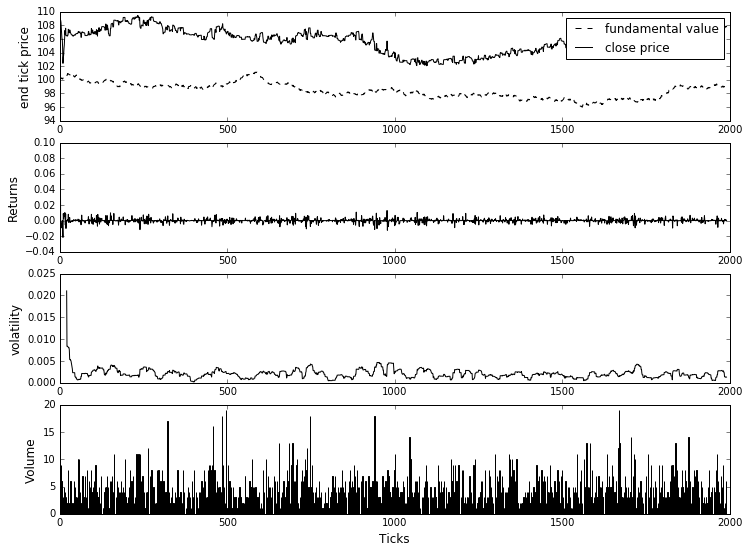

In [8]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()

ax2.plot(mc_returns.index, mc_returns.mean(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax3.set_ylabel('volatility', fontsize='12')

ax4.bar(mc_volume.index, mc_volume.mean(axis=1), color='k', edgecolor='k')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Ticks', fontsize='12')

# for ax in [ax1, ax2, ax3, ax4]:
#     ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

# Basic stylized facts

* **No autocorrelation** in returns
* **Volatility clustering** (marked by slowly decaying absolute autocorrelation)

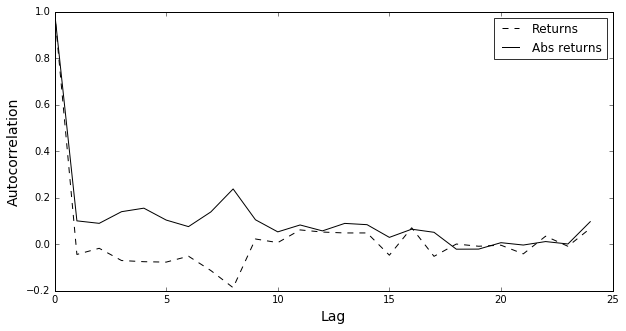

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

* **Excess Kurtosis**

In [10]:
mc_prices.mean(axis=1).kurtosis()

-0.65855049935140597

# Stationarity of the deviation from fundamentals

## Augmented Dickey-Fuller (ADF) Test

In [14]:
deviation_fund = mc_prices.mean(axis=1) - mc_fundamentals.mean(axis=1)


In [17]:
relative_deviation_fund = (mc_prices.mean(axis=1) - mc_fundamentals.mean(axis=1)) / mc_fundamentals.mean(axis=1)

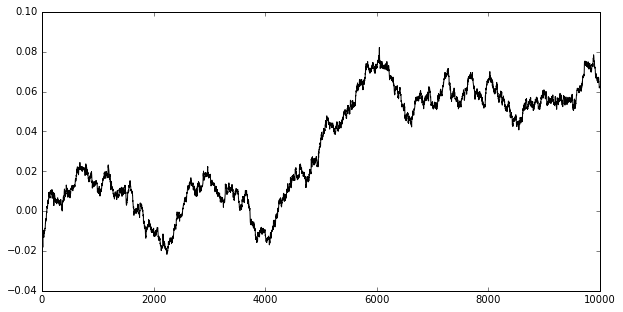

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.plot(mc_fundamentals.index, relative_deviation_fund, 'k-', label='deviation from fundamental value')


Following https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing, I perform a Dickey Fuller test to see if the deviations from fundamentals are a mean reverting process. But the calculated value of the test statistic is larger than any of the critical values at the 1, 5 or 10 percent levels, we cannot reject the null hypothesis of γ=0 and thus we are unlikely to have found a mean reverting time series.

In [19]:
ts.adfuller(relative_deviation_fund, 1)

(-1.175599750149428,
 0.68400304109120058,
 0,
 9991,
 {'1%': -3.4310046873093647,
  '10%': -2.566924006721353,
  '5%': -2.8618293328177886},
 -118710.44296116583)

## Hurst component

In [31]:
# Create a Gometric Brownian Motion, Mean-Reverting and Trending Series
gbm = np.log(np.cumsum(np.random.randn(100000))+1000)
mr = np.log(np.random.randn(100000)+1000)
tr = np.log(np.cumsum(np.random.randn(100000)+1)+1000)

# Output the Hurst Exponent for each of the above series
# and the price of Google (the Adjusted Close price) for 
# the ADF test given above in the article
print ("Hurst(GBM):   {}s".format(hurst(gbm)))
print ("Hurst(MR):    {}s".format(hurst(mr)))
print ("Hurst(TR):    {}s".format(hurst(tr)))

Hurst(GBM):   0.49167767158101283s
Hurst(MR):    -0.0001275825077730238s
Hurst(TR):    0.9556400687977785s


In [30]:
lags = range(2, 100)

# Calculate the array of the variances of the lagged differences
tau = [np.sqrt(np.std(np.subtract(gbm[lag:], gbm[:-lag]))) for lag in lags]

# Use a linear fit to estimate the Hurst Exponent
poly = np.polyfit(np.log(lags), np.log(tau), 1)

# Return the Hurst exponent from the polyfit output
poly[0]*2.0

0.50784008181648066

# Experiments

Index capitalism means a move from fundamentalist trading strategies to passive index following strategies. 

We simulate two scenarios:
1. Most technical traders are momentum traders
2. Most technical traders are mean reversion traders

Test effects on deviation from fundamentals and market volatility. 

In [9]:
parameters["w_fundamentalists"] = 10.0
parameters["w_buy_hold"] = 40.0
# experiment 1
parameters["w_momentum"] = 30.0
parameters["w_mean_reversion"] = 0.0
traders1 = []
obs1 = []
for seed in range(NRUNS): 
    trader1, orderbook1 = init_objects(parameters)
    trader1, orderbook1 = sim_fin_model(trader1, orderbook1, parameters, seed)
    traders1.append(trader1)
    obs1.append(orderbook1)
# experiment 2
parameters["w_momentum"] = 0.0
parameters["w_mean_reversion"] = 30.0
traders2 = []
obs2 = []
for seed in range(NRUNS): 
    trader2, orderbook2 = init_objects(parameters)
    trader2, orderbook2 = sim_fin_model(trader2, orderbook2, parameters, seed)
    traders2.append(trader2)
    obs2.append(orderbook2)

In [10]:
mc_prices1, mc_returns1, mc_autocorr_returns1, mc_autocorr_abs_returns1, mc_volatility1, mc_volume1, mc_fundamentals1 = organise_data(obs1)

In [11]:
mc_prices2, mc_returns2, mc_autocorr_returns2, mc_autocorr_abs_returns2, mc_volatility2, mc_volume2, mc_fundamentals2 = organise_data(obs2)

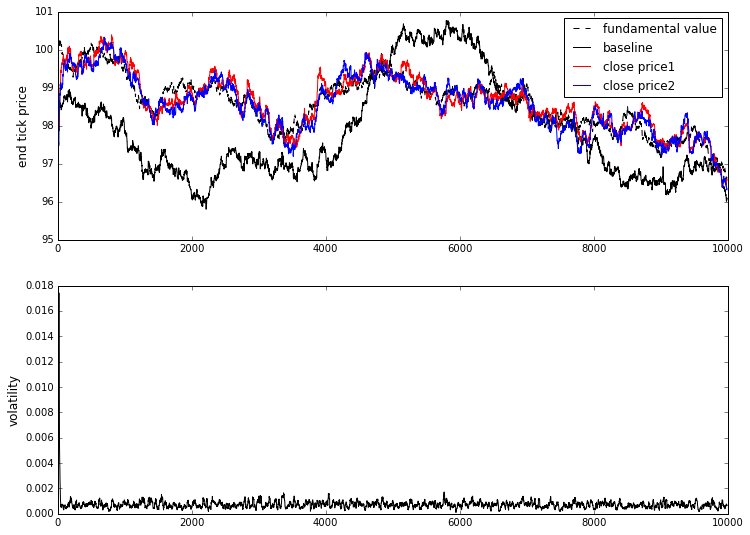

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals1.index, mc_fundamentals1.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k-', label='baseline')
ax1.plot(mc_prices1.index, mc_prices1.mean(axis=1), 'r-', label='close price1')
ax1.plot(mc_prices2.index, mc_prices2.mean(axis=1), 'b-', label='close price2')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()


ax2.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-')
ax2.set_ylabel('volatility', fontsize='12')


In [13]:
print(mc_prices.median(axis=1).std())
print(mc_prices1.median(axis=1).std())
print(mc_prices2.median(axis=1).std())

2.118156438994523
1.5859810039138347
1.6597851753557364


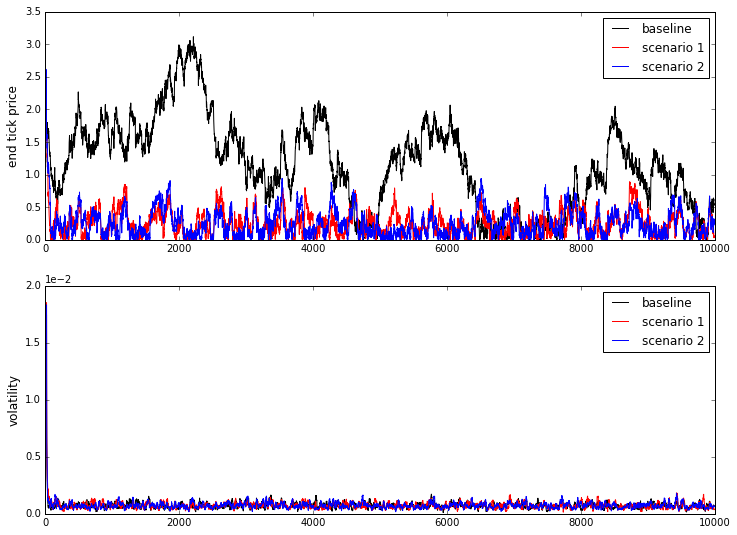

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,9))

ax1.plot(mc_fundamentals1.index, abs(mc_prices.mean(axis=1)-mc_fundamentals.mean(axis=1)), 'k-', label='baseline')
ax1.plot(mc_fundamentals1.index, abs(mc_prices1.mean(axis=1)-mc_fundamentals1.mean(axis=1)), 'r-', label='scenario 1')
ax1.plot(mc_fundamentals2.index, abs(mc_prices2.mean(axis=1)-mc_fundamentals2.mean(axis=1)), 'b-', label='scenario 2')

#ax1.plot(mc_prices1.index, mc_prices1.mean(axis=1), 'k-', label='close price1')
ax1.set_ylabel('end tick price', fontsize='12')
ax1.legend()

ax2.plot(mc_volatility.index, mc_volatility.mean(axis=1), 'k-', label='baseline')
ax2.plot(mc_volatility1.index, mc_volatility1.mean(axis=1), 'r-', label='scenario 1')
ax2.plot(mc_volatility2.index, mc_volatility2.mean(axis=1), 'b-', label='scenario 2')
ax2.set_ylabel('volatility', fontsize='12')
ax2.legend()

for ax in [ax1, ax2]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

## Export data

In [18]:
mc_prices.columns = ['Simulation_{}'.format(x) for x in range(10)]
mc_fundamentals.columns = ['Simulation_{}'.format(x) for x in range(10)]

In [19]:
writer = pd.ExcelWriter('sim-fin-mc-simulation.xlsx')
mc_prices.to_excel(writer,'prices')
mc_fundamentals.to_excel(writer,'fundamentals')
writer.save()